# Pareto-NBD Population Model



#### References:
----------
David C. Schmittlein, Donald G. Morrison and Richard Colombo
Management Science,Vol. 33, No. 1 (Jan., 1987), pp. 1-24
"Counting Your Customers: Who Are They and What Will They Do Next,"
    
Fader, Peter & G. S. Hardie, Bruce (2005).
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](http://brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In [30]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
import numpy as np
import warnings

from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_period_transactions

from pymc_marketing.clv.models import ParetoNBDModel
from pymc_marketing.clv.distributions import ParetoNBD
from pymc_marketing.clv.utils import clv_summary

## Load Data

We will be working with the CDNOW Sample dataset, a common benchmark dataset in research for CLV and BTYD models

In [2]:
url_cdnow_rfm = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/datasets/clv_quickstart.csv"
url_cdnow_trans = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/tests/clv/datasets/cdnow_transactions.csv"
df = pd.read_csv(url_cdnow_rfm)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       2357 non-null   int64  
 1   recency         2357 non-null   float64
 2   T               2357 non-null   float64
 3   monetary_value  2357 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 73.8 KB


In [3]:
df.head(5)

,frequency,recency,T,monetary_value
0,2,30.43,38.86,22.35
1,1,1.71,38.86,11.77
2,0,0.00,38.86,0.00
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00


In [4]:
df.describe()

,frequency,recency,T,monetary_value
count,2357.000000,2357.000000,2357.000000,2357.000000
mean,1.042427,6.845787,32.715829,14.079045
std,2.190014,10.731400,3.326906,25.760960
min,0.000000,0.000000,27.000000,0.000000
25%,0.000000,0.000000,29.860000,0.000000
50%,0.000000,0.000000,32.710000,0.000000
75%,1.000000,12.000000,35.430000,21.360000
max,29.000000,38.430000,38.860000,299.630000


In [5]:
x = df["frequency"].values
t_x = df["recency"].values
T = df["T"].values

## Lifetimes Comparison

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

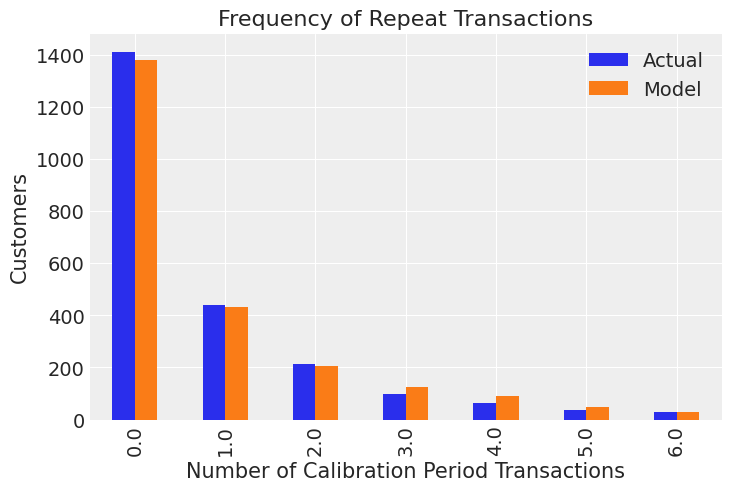

In [31]:
lft = ParetoNBDFitter()
lft.fit(x, t_x, T)

plot_period_transactions(lft)

In [7]:
lt_fit = dict(lft.params_)
ParetoNBDFitter._conditional_log_likelihood(list(lt_fit.values()), x, t_x, T).sum()

-9594.97392995759

Use the `ParetoNBD` distribution from `pymc-marketing` to simulate frequency and recency from fitted Lifetimes model parameters. This is useful for generating synthetic data as well as checking how well the parameters fit the original data.

This forms the basis of the `plot_period_transactions` plot from `lifetimes`.

In [126]:
rec_freq = pm.draw(ParetoNBD.dist(r=0.55,
                alpha=10.58,
                s=0.61,
                beta=11.67,
                T=T,
                size=len(T)))

pd.DataFrame({'frequency': rec_freq[...,1], 'recency': rec_freq[...,0], "T": T}).describe()

,frequency,recency,T
count,2357.000000,2357.000000,2357.000000
mean,1.016546,6.608408,32.715829
std,1.977629,10.641276,3.326906
min,0.000000,0.000000,27.000000
25%,0.000000,0.000000,29.860000
50%,0.000000,0.000000,32.710000
75%,1.000000,11.463860,35.430000
max,18.000000,37.806561,38.860000


<Axes: >

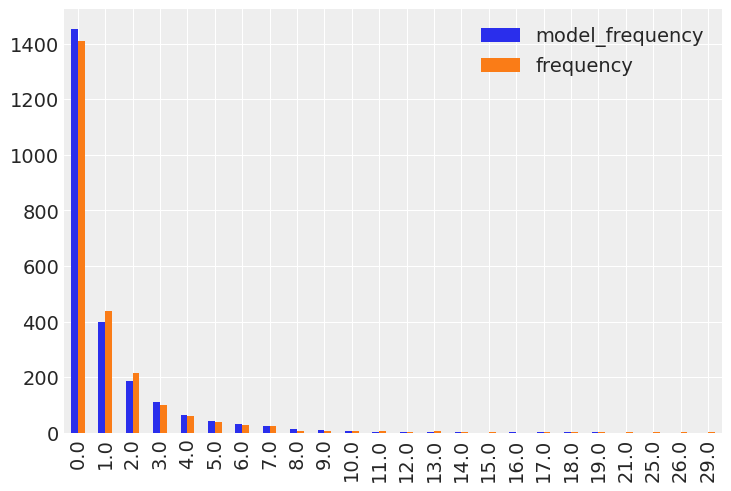

In [121]:
rec_freq = pm.draw(ParetoNBD.dist(r=0.55,
                alpha=10.58,
                s=0.61,
                beta=11.67,
                T=T,
                size=len(T)))

model_freq = rec_freq[...,1]

#sns.barplot([model_freq, x])

actual_counts = pd.Series(x).value_counts().sort_index()
simulated_counts = pd.Series(model_freq).value_counts().sort_index()
combined_counts = pd.DataFrame({"model_frequency": simulated_counts, "frequency": actual_counts}).fillna(0)
combined_counts.plot(kind="bar")

The Wasserstein Distance can be used as a metric to compare the distribution of actuals to that generated by the model.

In [9]:
from scipy.stats import wasserstein_distance

wasserstein_distance(combined_counts["model_frequency"].values,combined_counts["frequency"].values)


5.333333333333332

## PyMC Comparison

Construct an equivalent model with PyMC to illustrate the inner workings of the pymc-marketing model for comparison. 

This model uses Weibull default priors. For an interactive PDF go here:
https://homepage.divms.uiowa.edu/~mbognar/applets/weibull.html

The Weibull distribution is an intuitive prior distribution choice for the Pareto/NBD model because the `beta` parameter loosely corresponds to the expected value, and an `alpha` parameter value of 2 will rule out values which may cause sampling instability without being too restrictive. The Weibull distribution is also a variant of the generalized Gamma distribution that forms the conjugate priors of this model.

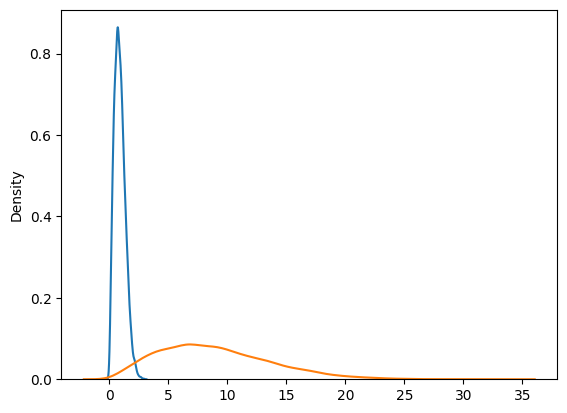

In [10]:
shape_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=1, size=10_000))
scale_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=10, size=10_000))

sns.kdeplot(shape_prior)
sns.kdeplot(scale_prior);

In [147]:
with pm.Model() as m1:
    r = pm.Weibull("r",alpha=2, beta=1)
    alpha = pm.Weibull("alpha", alpha=2, beta=10)
    s = pm.Weibull("s",alpha=2, beta=1)
    s = pm.HalfFlat("s")
    beta = pm.Weibull("beta", alpha=2, beta=10)
       
    llike = ParetoNBD("llike", r=r, alpha=alpha, s=s, beta=beta, T=T, observed=np.stack((t_x, x), axis=1))

pm.logp(llike, np.stack((t_x, x), axis=1)).sum().eval(dict(zip((r, alpha, s, beta), lt_fit.values())))

test_gamma = pm.draw(pm.Gamma.dist(alpha=1, beta=1,shape=4000))

ValueError: Variable name s already exists.

In [98]:
m1.basic_RVs
with m1 as m:
    dropout = pm.Gamma("dropout",alpha=r,beta=alpha)
m.basic_RVs

ValueError: Variable name dropout already exists.

NUTS sampling does not converge properly due to unstable gradients in the ParetoNBD logp function, so we must use the Slice Sampler instead.

Note the rhat statistic warning here: This means the MCMC sampling chains are not identically distributed. It is recommended to do at least 2000 draws with the Slice Sampler.

In [92]:
with m1:   
    with warnings.catch_warnings():
        warnings.filterwarnings(
            message="Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.",
            action="ignore",
            category=UserWarning,
        )
        # Default NUTS is too slow. 
        # In the pymc-experimental we include a special rewrite that speeds up the gradient evaluations
        idata_mcmc = pm.sample(step=pm.Slice(), draws=2000)
        # idata_jax = pymc.sampling_jax.sample_blackjax_nuts()#(2000, tune=2000, target_accept=0.9)
        #idata_map = pm.find_MAP(include_transformed=False)
        # mean_field = pm.fit(obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
        
        # module AttributeError: module 'jax.scipy.special' has no attribute 'hyp2f1'

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [r]
>Slice: [alpha]
>Slice: [s]
>Slice: [beta]
>Slice: [dropout]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [55]:
idata_mcmc

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [27]:
az.summary(idata_mcmc)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.563,0.047,0.478,0.650,0.002,0.001,761.0,1639.0,1.00
alpha,10.688,0.853,9.097,12.267,0.028,0.020,909.0,2086.0,1.00
s,0.610,0.118,0.405,0.845,0.006,0.004,422.0,564.0,1.01
beta,11.700,3.757,5.337,19.061,0.188,0.133,399.0,571.0,1.01


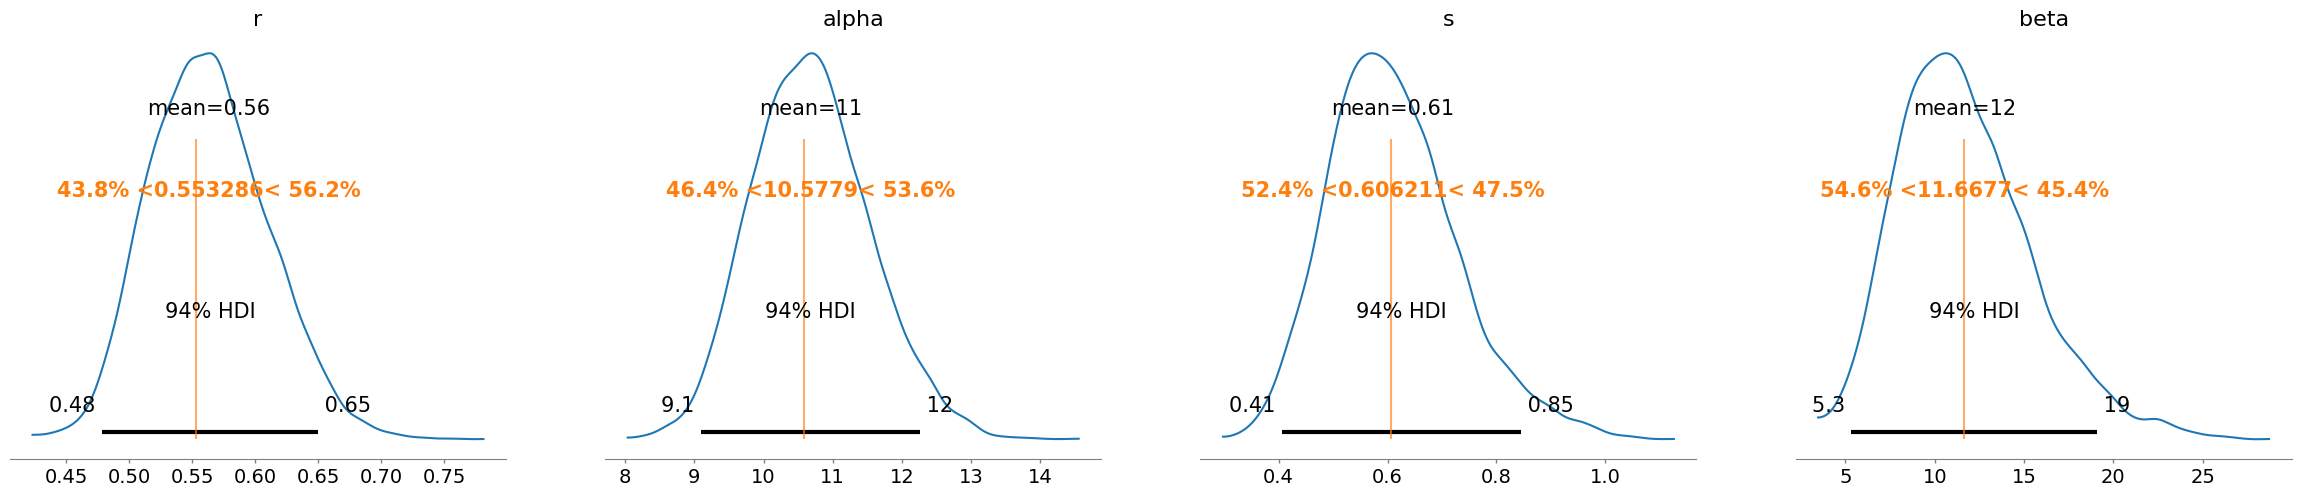

In [28]:
az.plot_posterior(idata_mcmc, ref_val=list(lt_fit.values()));

# ParetoNBD Model in `pymc_marketing`

Build models fit with both MAP and MCMC

In [159]:
df['customer_id'] = df.index


# TODO: build_model() and fit() methods both return NoneType objects
pnbd_map = ParetoNBDModel(df)
pnbd_map.build_model()

pnbd_map.fit(fit_method='map')
pnbd_map.distribution_new_customer_dropout()

#pnbd_map.idata.prior["r"]
# TODO: Using pm.Slice() for inference requires changes to the ModelBuilder backend
# pnbd = ParetoNBDModel(df)
# pnbd.build_model()
#pnbd.sample_prior_predictive()
# pnbd.fit()

/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/models/pareto_nbd.py:172: UserWarning: The Pareto/NBD model is still experimental. Please see code examples in documentation if model fitting issues are encountered.
  warnings.warn(


Sampling: [population_dropout]


<xarray.DataArray 'population_dropout' (chain: 1, draw: 1,
                                        population_dropout_dim_2: 4000)>
array([[[4.06775523e-01, 6.70330646e-03, 2.63183098e+00, ...,
         1.45243752e+01, 2.62611263e+00, 2.88286426e-01]]])
Coordinates:
  * chain                     (chain) int64 0
  * draw                      (draw) int64 0
  * population_dropout_dim_2  (population_dropout_dim_2) int64 0 1 ... 3998 3999

In [162]:
#pnbd_map.idata.posterior["r"]
pnbd_map._distribution_new_customers()

Sampling: [population_dropout, population_purchase_rate]


<xarray.Dataset>
Dimensions:                         (chain: 1, draw: 1,
                                     population_dropout_dim_2: 4000,
                                     population_purchase_rate_dim_2: 4000)
Coordinates:
  * chain                           (chain) int64 0
  * draw                            (draw) int64 0
  * population_dropout_dim_2        (population_dropout_dim_2) int64 0 ... 3999
  * population_purchase_rate_dim_2  (population_purchase_rate_dim_2) int64 0 ...
Data variables:
    population_dropout              (chain, draw, population_dropout_dim_2) float64 ...
    population_purchase_rate        (chain, draw, population_purchase_rate_dim_2) float64 ...
Attributes:
    created_at:                 2023-07-19T11:51:07.944023
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.6.1

In [168]:
chains = 2
draws = 50
mock_fit = az.from_dict(
    {
        "r": [.66],
        "alpha": [10],
        "s": [.55],
        "beta": [11],
    }
)

mock_fit.posterior["r"][0][0]

<xarray.DataArray 'r' ()>
array(0.66)
Coordinates:
    chain    int64 0
    draw     int64 0

In [21]:
print("MAP Fit:") 
print(pnbd_map.fit_summary())

pnbd.fit_summary()

MAP Fit:
r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64


RuntimeError: The model hasn't been fit yet, call .fit() first

r_hat statistics looks good, but is the Energy Plot Concerning?
https://python.arviz.org/en/stable/api/generated/arviz.plot_energy.html

<Axes: >

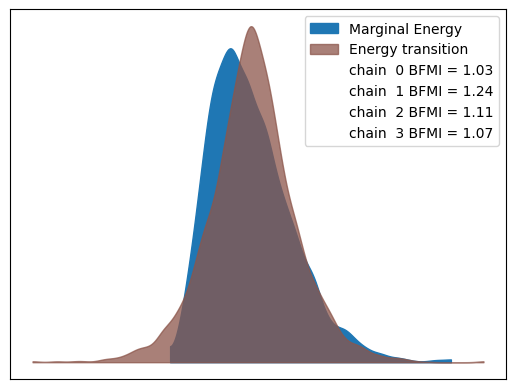

In [57]:
az.plot_energy(pnbd.idata)

Sampling: [alpha, beta, likelihood, r, s]


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

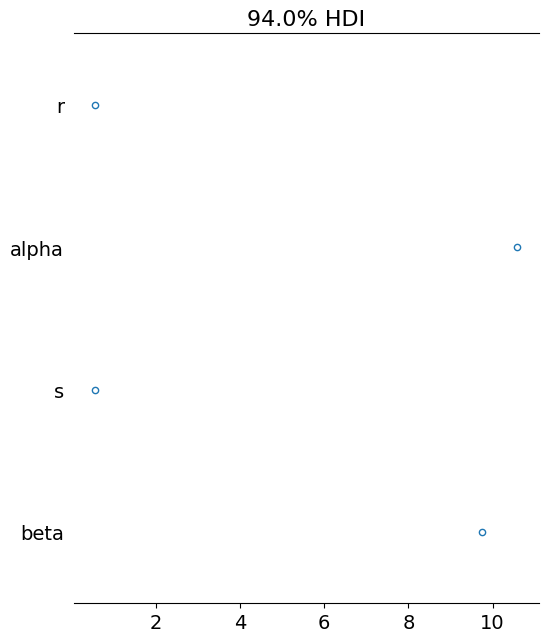

In [24]:
pnbd_map.sample_prior_predictive()

#az.plot_dist_comparison(pnbd.idata)
az.plot_forest(pnbd_map.idata)

<Axes: title={'center': 'Plot Prior Predictive'}>

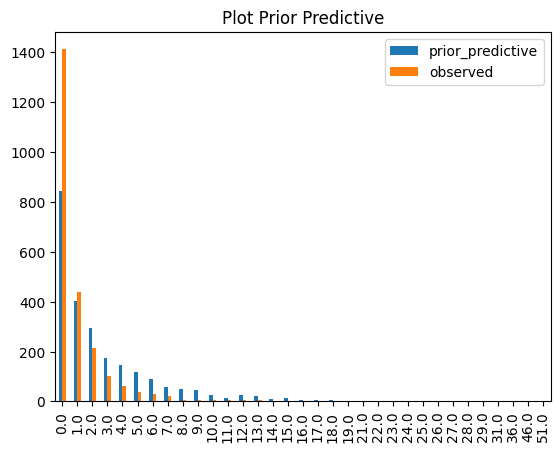

In [25]:
obs_freq = pnbd_map.idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
prior_pred_freq = pnbd_map.idata.prior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

plot_prior_pred = pd.DataFrame({"prior_predictive": prior_pred_freq, "observed": obs_freq})
plot_prior_pred.plot(kind="bar", title = "Plot Prior Predictive")

<Axes: >

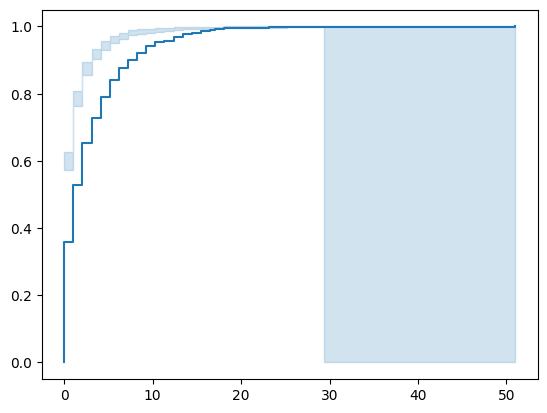

In [26]:
obs_freq = pnbd_map.idata.observed_data['likelihood'][...,1]
prior_pred_freq = pnbd_map.idata.prior_predictive['likelihood'][0][0][...,1]

az.plot_ecdf(prior_pred_freq, obs_freq, confidence_bands = True)

Sampling: [likelihood]


<Axes: title={'center': 'Plot Post Predictive'}>

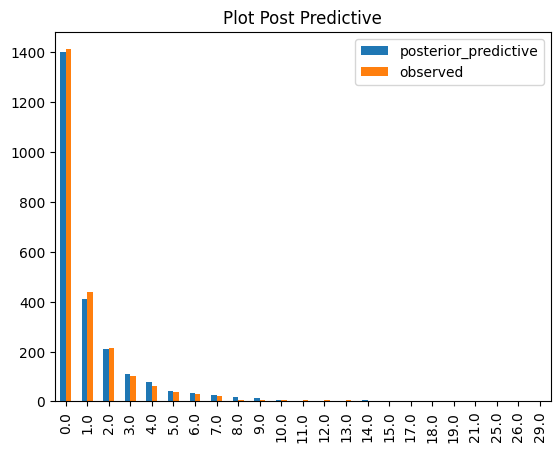

In [27]:
with pnbd_map.model:
    post_idata = pm.sample_posterior_predictive(pnbd_map.idata)

obs_freq = post_idata.observed_data['likelihood'][...,1].to_pandas().value_counts().sort_index()
post_pred_freq = post_idata.posterior_predictive['likelihood'][0][0][...,1].to_pandas().value_counts().sort_index()

plot_posterior_pred = pd.DataFrame({"posterior_predictive": post_pred_freq, "observed": obs_freq})

plot_posterior_pred.plot(kind="bar", title = "Plot Post Predictive")

https://python.arviz.org/en/stable/api/generated/arviz.plot_ecdf.html#arviz.plot_ecdf

Text(0.5, 1.0, 'ECDF')

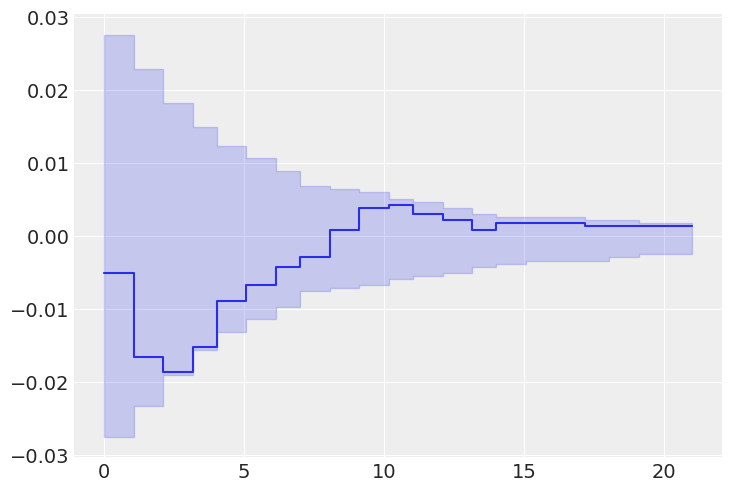

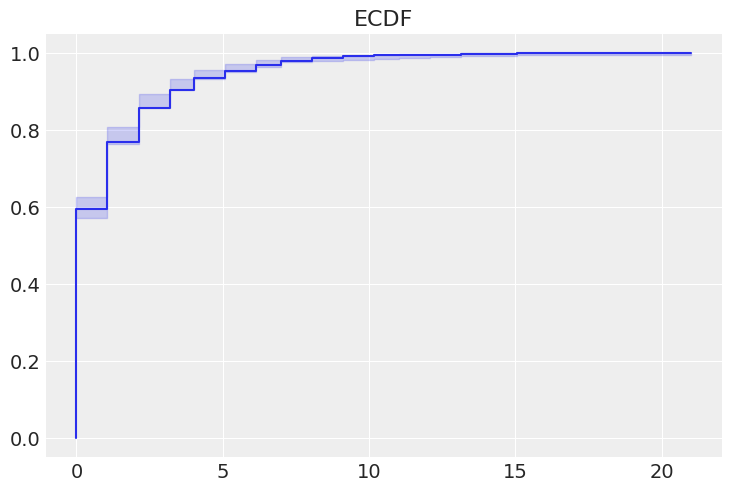

In [28]:
plt.style.use('arviz-darkgrid')

obs_freq = post_idata.observed_data['likelihood'][...,1]
post_pred_freq = post_idata.posterior_predictive['likelihood'][0][0][...,1]

az.plot_ecdf(post_pred_freq, obs_freq, confidence_bands = True, difference=True)
az.plot_ecdf(post_pred_freq, obs_freq, confidence_bands = True).set_title("ECDF")

array([<Axes: title={'center': 'r'}>, <Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 's'}>, <Axes: title={'center': 'beta'}>],
      dtype=object)

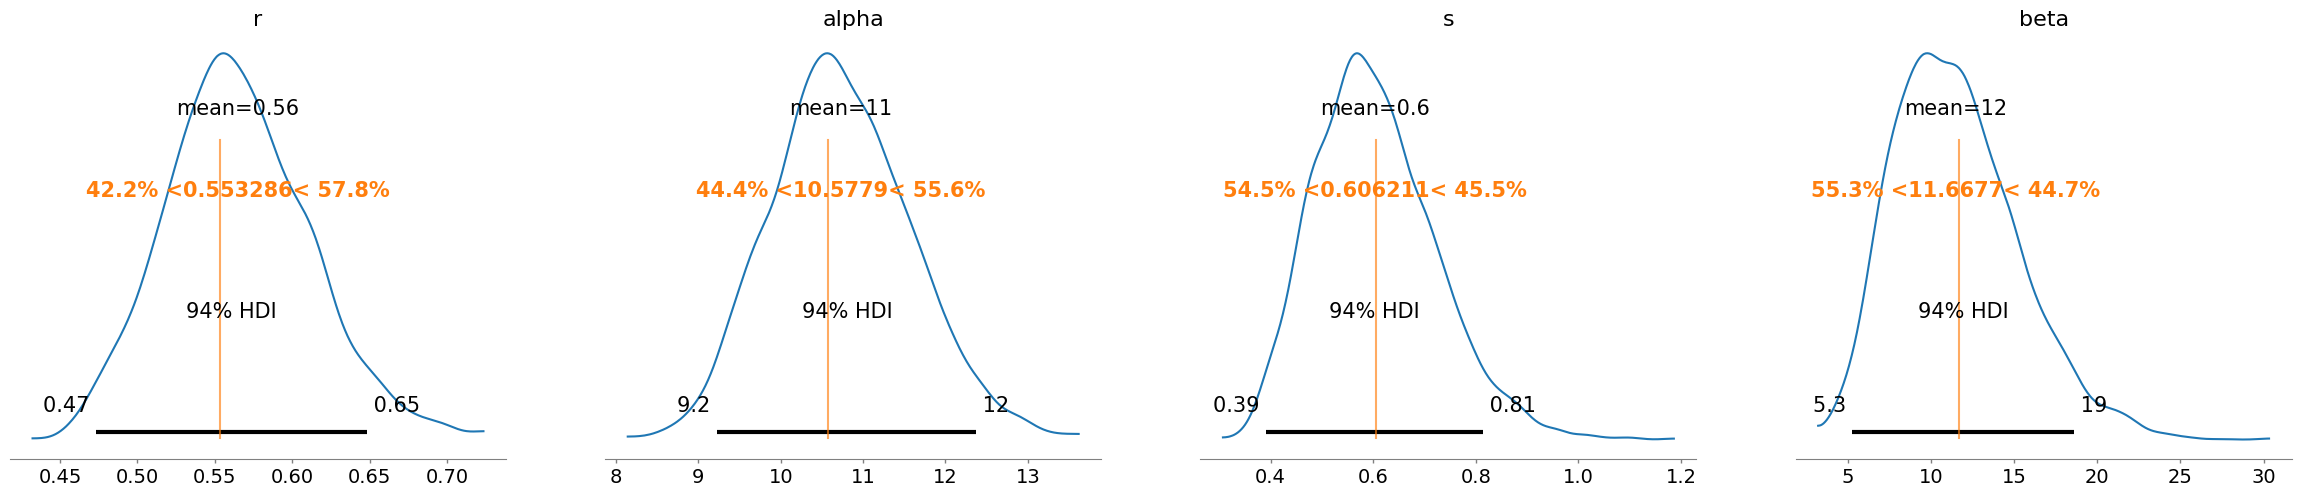

In [84]:
az.plot_posterior(pnbd.idata, ref_val=list(lt_fit.values()))

# Plot the `ParetoNBDModel` Dropout and Purchase Rate Distributions for New Customers

In [142]:
plt.style.use('arviz-darkgrid')

customer_dropout = pnbd_map.distribution_new_customer_dropout()
customer_purchase_rate = pnbd_map.distribution_new_customer_purchase_rate()

# TODO: This only works for a model fit with MCMC
# az.plot_density(customer_dropout[0][0],point_estimate="mean", shade=.75)
# az.plot_density(customer_purchase_rate[0][0],point_estimate="mean", shade=.75)
customer_dropout[0][0]

Sampling: [population_dropout]


Sampling: [population_purchase_rate]


<xarray.DataArray 'population_dropout' (population_dropout_dim_2: 4000)>
array([ 0.15286546, 24.42239795,  3.3613876 , ..., 10.21854813,
        1.9246427 ,  3.73307827])
Coordinates:
    chain                     int64 0
    draw                      int64 0
  * population_dropout_dim_2  (population_dropout_dim_2) int64 0 1 ... 3998 3999

In [117]:
#pm.draw(pm.Gamma.dist(alpha=1, beta=1,shape=1000))

pnbd_map.sample_prior_predictive()

Sampling: [alpha, beta, likelihood, r, s]


<xarray.Dataset>
Dimensions:           (customer_id: 2357, likelihood_dim_1: 2, sample: 1000)
Coordinates:
  * customer_id       (customer_id) int64 0 1 2 3 4 ... 2352 2353 2354 2355 2356
  * likelihood_dim_1  (likelihood_dim_1) int64 0 1
  * sample            (sample) object MultiIndex
  * chain             (sample) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw              (sample) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    likelihood        (customer_id, likelihood_dim_1, sample) float64 1.202 ....
Attributes:
    created_at:                 2023-07-19T10:59:02.069762
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.6.1

### Use `az.plot_dist()` for additional plotting options like rugplots and quantiles)

Text(0.5, 1.0, 'Customer Purchase Rate Distribution')

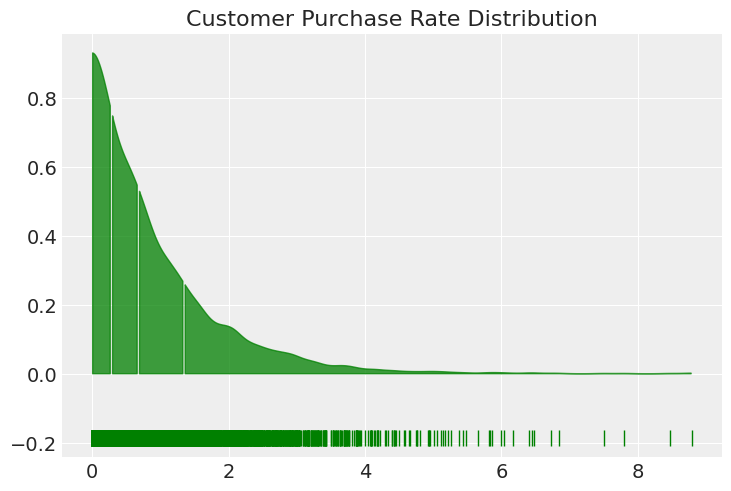

In [144]:
#az.plot_dist(customer_dropout[0][0], rug=True, quantiles=[.25, .5, .75], cumulative=False).set_title("Customer Dropout Distribution")

az.plot_dist(test_gamma, rug=True, color='g', quantiles=[.25, .5, .75], cumulative=False).set_title("Customer Purchase Rate Distribution")

# Predictive Methods for `ParetoNBDModel`

In [24]:
pnbd_map.save('pnbd.nc')
pnbd_map.load('pnbd.nc')

# Append all predictive methods to a pandas dataframe
#df['exp_prchs_mcmc'] = pnbd_mcmc.expected_purchases(future_t = 10).mean(("chain", "draw"))
df['exp_prchs_map'] = pnbd_map.expected_purchases(future_t = 10).mean(("chain", "draw"))

#df['prob_alive_mcmc'] = pnbd_mcmc.expected_probability_alive(future_t = 10).mean(("chain", "draw"))
df['prob_alive_map'] = pnbd_map.expected_probability_alive(future_t = 10).mean(("chain", "draw"))

#df['prchs_prob_mcmc'] = pnbd_mcmc.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))
df['prchs_prob_map'] = pnbd_map.expected_purchase_probability(n_purchases=3,future_t=30).mean(("chain", "draw"))

# This value does not change from customer to customer, but is shown here for completeness
#df['new_customer_mcmc'] = pnbd_mcmc.expected_purchases_new_customer(t = 100).mean().values
df['new_customer_map'] = pnbd_map.expected_purchases_new_customer(t = 100).mean().values

# For single customer predictions, arguments must still be provided as lists or numpy arrays
# Array lengths must match for all arguments
# pnbd_mcmc.expected_purchases(future_t = 10,
#                              customer_id = [1000],
#                              frequency = np.array([3]),
#                              recency = [20],
#                              T = [30]).mean(("chain", "draw"))

# # Use a for loop or list comprehension to iterate over multiple arguments:
# [pnbd_mcmc.expected_purchases(future_t = t) for t in [10,9,8]]

df.head(10)

/Users/coltallen/miniconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/data/inference_data.py:152: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(
/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/models/pareto_nbd.py:175: UserWarning: The Pareto/NBD model is still experimental. Please see code examples in documentation if model fitting issues are encountered.
  warnings.warn(


,frequency,recency,T,monetary_value,customer_id,exp_prchs_mcmc,exp_prchs_map,prob_alive_mcmc,prob_alive_map,prchs_prob_map,new_customer_map
0,2,30.43,38.86,22.35,0,0.426163,0.429898,0.781540,0.789804,0.082505,2.257801
1,1,1.71,38.86,11.77,1,0.049964,0.050083,0.150524,0.151008,0.008571,2.257801
2,0,0.00,38.86,0.00,2,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
3,0,0.00,38.86,0.00,3,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
4,0,0.00,38.86,0.00,4,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
5,7,29.43,38.86,73.74,5,1.087263,1.102017,0.675588,0.685516,0.110536,2.257801
6,1,5.00,38.86,11.77,6,0.076542,0.077453,0.230524,0.233532,0.013254,2.257801
7,0,0.00,38.86,0.00,7,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801
8,2,35.71,38.86,25.55,8,0.469376,0.471763,0.860708,0.866718,0.090540,2.257801
9,0,0.00,38.86,0.00,9,0.031313,0.031521,0.263049,0.264870,0.003761,2.257801


# Formatting Data From Raw Transactions
Why isn't clv_summary() working here?

In [65]:
d = [
        [1, "2015-01-01", 10.11],
        [1, "2015-02-06", 20.12],
        [2, "2015-01-01", 26.13],
        [3, "2015-01-01", 33.2],
        [3, "2015-01-02", 11.12],
        [3, "2015-01-05", 55.1],
        [4, "2015-01-16", 66.12],
        [4, "2015-02-02", 33.1],
        [4, "2015-02-05", 31.1],
        [5, "2015-01-16", 39.7],
        [5, "2015-01-17", 19.5],
        [5, "2015-01-18", 80.1],
    ]

raw_trans = pd.DataFrame(d, columns=["customer_id", "purchase_date", "monetary_value"])
raw_trans['purchase_date'] = pd.to_datetime(raw_trans['purchase_date'])
raw_trans

clv_summary(raw_trans,"customer_id","purchase_date","monetary_value")

# TODO: Why isn't CLV_Summary working here?
url_cdnow_trans = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/tests/clv/datasets/cdnow_transactions.csv"
raw_trans = pd.read_csv(url_cdnow_trans)
datetime_format = "%Y%m%d"

raw_trans['date'] = raw_trans['date'].astype(str)
df_rfm = clv_summary(raw_trans,"id","date")#,datetime_format=datetime_format)

In [66]:
df_rfm.describe()

,id,frequency,recency,T
count,2357.000000,2357.000000,2357.000000,2357.000000
mean,1179.000000,1.840899,130.447179,502.011031
std,680.551615,3.772237,176.874156,23.288656
min,1.000000,0.000000,0.000000,462.000000
25%,590.000000,0.000000,0.000000,482.000000
50%,1179.000000,0.000000,0.000000,502.000000
75%,1768.000000,2.000000,279.000000,521.000000
max,2357.000000,43.000000,535.000000,545.000000


In [ ]:
    def distribution_new_customer_dropout(
        self,
        ppc: str = 'posterior',
        random_seed: Optional[RandomState] = None,
    ) -> xarray.Dataset:
        """Sample from the Gamma distribution representing dropout times for new customers.

        This is the duration of time a new customer is active before churning, or dropping out.

        Parameters
        ----------
        ppc: str
            Specify 'prior' for a prior predictive check,
            or 'posterior' for a posterior predictive check on the fitted model.
        random_seed: RandomState, optional
            Random state to use for sampling.

        Returns
        -------
        xr.Dataset
            Dataset containing the posterior samples for the population-level dropout rate.
        """

        if ppc not in ['prior', 'posterior']:
            raise ValueError("ppc must be either 'prior' or 'posterior'.")
        elif ppc == 'prior':
            params = self.idata.prior
        elif ppc == 'posterior':
            params = self.idata.posterior

        return pm.draw(pm.Gamma.dist(alpha=params['s'], beta=1/params['beta'], shape=4000),random_seed=random_seed)


    E       NotImplementedError: Cannot convert <xarray.DataArray 's' (draw: 1)>
E       array([0.6061])
E       Coordinates:
E           chain    int64 0
E         * draw     (draw) int64 0 to a tensor variable.


In [ ]:
def simulate_new_customers(self,
                           random_seed: Optional[RandomState] = None,
                           T_observations: Union[None, float, np.ndarray, pd.Series] = None
                           ) -> pd.DataFrame:
    """Simulate new customers from model parameters"""

    if T_observations is None:
        T_observations = self.T

    rec_freq = pm.draw(ParetoNBD.dist(
        r=self.idata.posterior["r"],
        alpha=self.idata.posterior["alpha"],
        s=self.idata.posterior["s"],
        beta=self.idata.posterior["beta"],
        T=T_observations),
        size=len(T_observations)
    )

    new_customer_df = pd.DataFrame({'frequency': rec_freq[...,1], 'recency': rec_freq[...,0], "T": T}).describe()
